In [1]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
from astropy.cosmology import Planck15 as cosmo
from IPython import display

# adding path to GPR_for_IM directory in order to import relevant scripts
import sys
sys.path.append('../')
import pk_tools as pk
import fg_tools as fg
import obs_tools as obs
import load_datacube as load

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

## Power spectrum bias correction

Here we will look at the Mertens et al. 2020 (M20; https://arxiv.org/pdf/2002.07196.pdf) method of unbiasing the recovered power spectrum of the GPR residual (the signal left after performning foreground removal).

M20 use a Monte Carlo procedure to do this correction (this is the __analytic FG error__):
1. First, draw a lot of random realisation of the data described by the foreground covariance (`fg_cov`)
2. Measure the power spectrum of each of these realisations
3. Average these power spectra
4. Add the averaged power spectrum to the residual power spectrum

The catch to this particular correction is that it assumes we know our 21cm covariance, i.e. the estimated 21cm covariance found by GPR is the real one. If this is not the case, it can lead to an overprediction or underprediction of the 21cm power spectrum, depending on whether the 21cm covariance is overpredicted or underpredicted.

This analytic correction should be equivalent to subtracting the foreground prediction from the true foreground signal (this is the __actual FG error__).

_The analytic and actual FG errors should be very similar._

Mertens demonstrates both of these bias corrections (analysic and actual) in this notebook: https://gitlab.com/flomertens/ps_eor/-/blob/master/doc/GPR%20theory%20and%20practice.ipynb

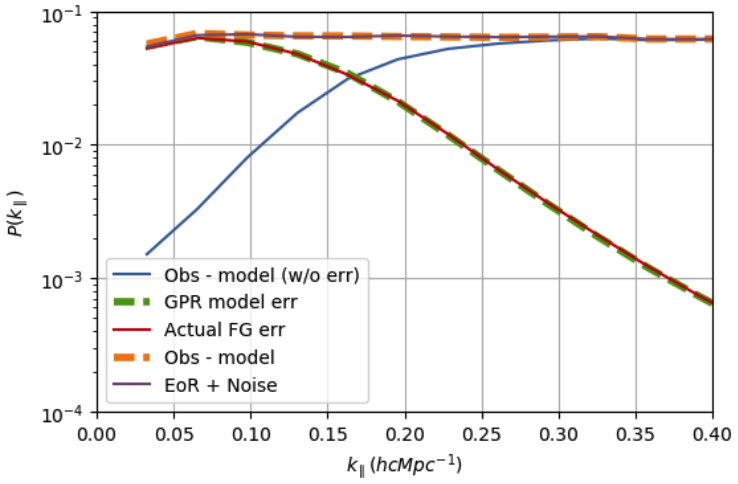

In [3]:
display.Image("../images/Mertens_bias_correction.png")

## Loading data

In [4]:
FGnopol_data = (np.load('../Data/dT_sync_Stripe82_noBeam.npy')
                + np.load('../Data/dT_free_Stripe82_noBeam.npy')
                + np.load('../Data/dT_psource_Stripe82_noBeam.npy'))
HI_data = np.load('../Data/T_HI-MDSAGE_z_0.39.npy')
HI_data = np.swapaxes(HI_data, 1, 2)
noise_data = np.load('../Data/dT_noise.npy')

Smoothing maps by constant telescope beam:

In [5]:
# smoothing maps
lx,ly,lz = 1000, 1000, 924.78 #Mpc/h
zmax = 0.58
sigma_beam = 1.55
FGnopol_HI_noise_smoothed = obs.ConvolveCube(FGnopol_data+HI_data+noise_data,zmax,lx,ly,sigma_beam, cosmo)
HI_noise_smoothed = obs.ConvolveCube(HI_data+noise_data,zmax,lx,ly,sigma_beam, cosmo)
noise_smoothed = obs.ConvolveCube(noise_data,zmax,lx,ly,sigma_beam, cosmo)
FGnopol_data_smoothed = obs.ConvolveCube(FGnopol_data,zmax,lx,ly,sigma_beam, cosmo)

## Running GPR

Defining input data and frequency range:

In [6]:
df = 1 # frequency resolution of data (MHz)
vmin = 899 # min frequency (MHz)
vmax = 1184 # max frequency (MHz)
freqs = np.arange(vmin, vmax, df)
Input = FGnopol_HI_noise_smoothed

Setting kernels for the different signals (RBF for smooth foregrounds, Exponential for 21cm and noise combined). The best fit values for the variance and lengthscale were obtained using the Nested Sampling package `pymultinest`.

In [7]:
# kernel for the smooth foreground:
kern_fg = GPy.kern.RBF(1, variance=162512.06549802964, lengthscale=494.544883186941)
# kernel for the HI cosmological signal:
kern_21 = GPy.kern.Exponential(1, variance=0.0010800143737052627, lengthscale=5.938678799344708)

Running GPR cleaning function (without optimising the model, since we already know the best fit hyperparameters, so we set `num_restarts=0`), to obtain:
- `gpr_res`: the residual goreground removed data
- `fg_cov`: the foreground covariance (error in the foreground fit), used for the bias correction
- `model`: the optimised GPR model
- `fg_fit`: the foreground fit, which is removed from the data to yield the residual `gpr_res`

In [8]:
gpr_res, fg_cov, model = fg.GPRclean(Input, freqs, kern_fg, kern_21, NprePCA=0, num_restarts=0, 
                                      noise_data=None, heteroscedastic=False, zero_noise=True, invert=True)
# this extracts the foreground fit:
fg_fit, fg_cov = model.predict(freqs[:, np.newaxis], full_cov=True, kern=model.kern.rbf,
        include_likelihood=False)

 /opt/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /opt/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


In [9]:
model

GP_regression.,value,constraints,priors
sum.rbf.variance,162512.06549802964,+ve,
sum.rbf.lengthscale,494.544883186941,+ve,
sum.Exponential.variance,0.001080014373705263,+ve,
sum.Exponential.lengthscale,5.938678799344708,+ve,
Gaussian_noise.variance,0.0,+ve fixed,


Let's take a look at the foreground covariance and what it looks like:

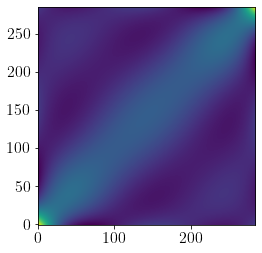

In [10]:
plt.imshow(fg_cov, origin='lower')

Let's also look at what the foreground residuals (`fg_res`) look like. These are the foreground data minus the foreground fit (`fg_fit`). It looks similar but not exactly the same as above - there are some off diagonal components that we don't see in the foreground covariance.

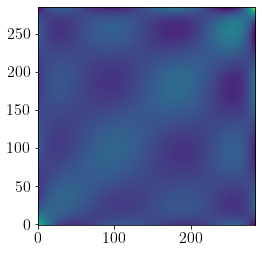

In [11]:
FGnopol_data_smoothed_los = load.LoSpixels(FGnopol_data_smoothed)
FGnopol_data_smoothed_los = FGnopol_data_smoothed_los[::-1]
fg_res = FGnopol_data_smoothed_los-fg_fit
fg_cov_actual = np.cov(fg_res)

plt.imshow(fg_cov_actual, origin='lower')

## Approximate bias correction

### Step 1. Draw a lot of random realisation of the data described by the covariance of the foreground fit `fg_cov`

In [12]:
n_pix, n_freqs = Input.shape[0]*Input.shape[1], Input.shape[2]

mu = np.zeros(n_freqs)# vector of the means, zero
n_samples = 20

# Generate n separate samples paths from a Gaussian with mean mu and covariance fg_cov:
samples = []
for i in range(n_samples):
    s = np.random.multivariate_normal(mu, fg_cov, (Input.shape[0]*Input.shape[1]))# * Input.std() * noise_smoothed.std()
    s = s[::-1]
    s = np.reshape(s,(Input.shape[0], Input.shape[1], Input.shape[2]))
    #s = obs.ConvolveCube(s, zmax, lx, ly, sigma_beam, cosmo) # smoothing by telescope beam
    samples.append(s)

samples = np.array(samples)

Let's compare these samples to the actual foreground residuals. They look similar in the LoS direction.

Text(0, 0.5, 'Temperature (mK)')

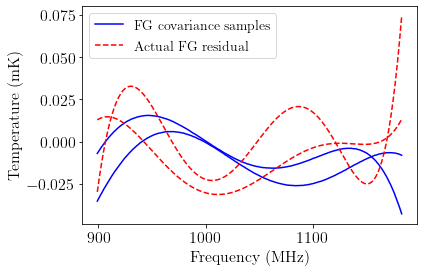

In [13]:
plt.plot(freqs, load.LoSpixels(samples[9])[:,10], c='b', label='FG covariance samples')
plt.plot(freqs, load.LoSpixels(samples[9])[:,2000], c='b')
plt.plot(freqs, fg_res[:,10], ls='dashed', c='r', label='Actual FG residual')
plt.plot(freqs, fg_res[:,200], ls='dashed', c='r')

plt.legend(fontsize=14)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (mK)')

Let's also compare the actual foreground residual data cube, to one of the FG covariance samples datacube. Since we've already compared the LoS component, we can now compare redshift slices. As seen below, __they do not look similar__. This is because when we generate the FG covariance samples, we only have the frequency covariance information, we have no spatial information in the transverse to the LoS direction, so the redshift slices are essentially random noise. 

The foreground residual on the other hand, has the transverse to the LoS information since we get it directly from the data.

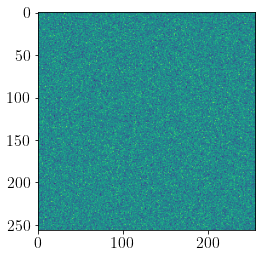

In [14]:
plt.imshow(samples[0][:,:,10])

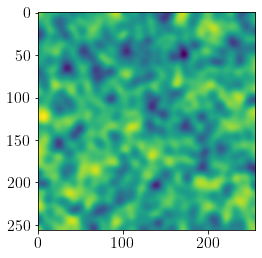

In [15]:
fg_res = np.swapaxes(fg_res,0,1)
fg_res = np.reshape(fg_res,(Input.shape[0], Input.shape[1], Input.shape[2]))

plt.imshow(fg_res[:,:,10])

To demonstrate this difference further, let's create a random sample using the covariance of the actual foreground residuals. We see that we get again only random noise in the transverse direction.

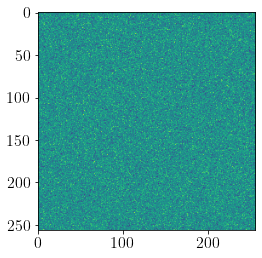

In [16]:
sample_fg_res = np.random.multivariate_normal(mu, fg_cov_actual, (Input.shape[0], Input.shape[1]))

plt.imshow(sample_fg_res[:,:,10])

Let's compare the power spectra of the approximate and actual bias corrections.

In [17]:
# minimum and maximum k in each direction:
kmin = 2*np.pi/pow(lx*ly*lz, 1/3)
kmin_perp = 2*np.pi/np.sqrt(lx**2 + ly**2)
kmin_par = 2*np.pi/lz
kmax = 0.5
kmax_par= 0.5
kmax_perp = 0.5

# set width of k bins to be 2*kmin
dk = 2*kmin
dk_perp = 2*kmin_perp
dk_par = 2*kmin_par

# number of k bins:
nkbin = int((kmax-kmin)/dk)
nkbin_perp = int((kmax_perp-kmin_perp)/dk_perp)
nkbin_par = int((kmax_par-kmin_par)/dk_par)

# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
kbins_perp = np.arange(kmin_perp,kmax_perp,dk_perp)
kbins_par = np.arange(kmin_par,kmax_par,dk_par)

# array of kbin centers:
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
kperp = np.linspace(kmin_perp+0.5*dk_perp,kmax_par-0.5*dk_perp,nkbin_perp)
kpar = np.linspace(kmin_par+0.5*dk_par,kmax_perp-0.5*dk_par,nkbin_par)

# Dimension of data cube:
nx,ny,nz = 256, 256, 285
# weighting and window function:
w = W = np.ones((nx,ny,nz))

### Step 2. Measure the power spectra of our samples

Here we also measure the 1D parallel and perpendicular to the LoS power spectra, which we will use for analysis.

In [18]:
pk_corr = []
pk_corr_para = []
pk_corr_perp = []

for s in samples:
    pk_corr.append(pk.getpk(s,w,W,nx,ny,nz,lx,ly,lz,kbins)[0])
    pk_corr_para.append(pk.ParaPk(s, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0])
    pk_corr_perp.append(pk.PerpPk(s, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0])

### Step 3. Average these power spectra

In [19]:
pk_corr = np.mean(pk_corr, axis=0)
pk_corr_para = np.mean(pk_corr_para, axis=0)
pk_corr_perp = np.mean(pk_corr_perp, axis=0)

Measuring the same power spectra for the actual bias correction:

In [20]:
pk_truecorr = pk.getpk(fg_res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
pk_truecorr_para = pk.ParaPk(fg_res, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
pk_truecorr_perp = pk.PerpPk(fg_res, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

Plotting all the power spectra in order to compare these two bias corrections:

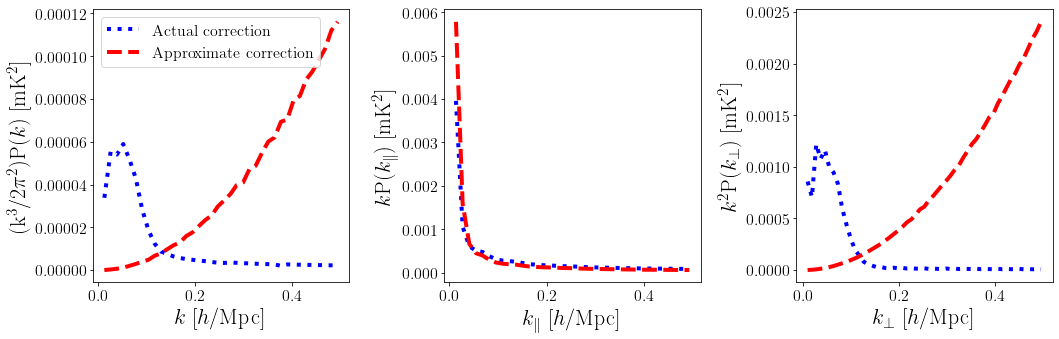

In [21]:
fig = plt.figure(figsize=(15,5))   # open a new plotting window

plt.subplot(131)
plt.plot(k, (k*k*k*pk_truecorr)/(2*np.pi*np.pi), lw=4, ls='dotted', c='b', label="Actual correction")
plt.plot(k, (k*k*k*pk_corr)/(2*np.pi*np.pi), lw=4, ls='dashed', c='r', label='Approximate correction')
plt.legend()
plt.xlabel('$k$ [$h$/Mpc]', fontsize=22)
plt.ylabel('(k$^3$/2$\pi^2$)P($k$) [mK$^2$]', fontsize=22)

plt.subplot(132)
plt.plot(kpar, kpar*pk_truecorr_para, lw=4, ls='dotted', c='b', label="Analytic correction")
plt.plot(kpar, kpar*pk_corr_para, lw=4, ls='dashed', c='r', label='Actual correction')
plt.xlabel('$k_\parallel$ [$h$/Mpc]', fontsize=22)
plt.ylabel('$k$P($k_\parallel$) [mK$^2$]', fontsize=22)

plt.subplot(133)
plt.plot(kperp, kperp*kperp*pk_truecorr_perp, lw=4, ls='dotted', c='b', label="Analytic correction")
plt.plot(kperp, kperp*kperp*pk_corr_perp, lw=4, ls='dashed', c='r', label='Actual correction')
plt.xlabel('$k_\perp$ [$h$/Mpc]', fontsize=22)
plt.ylabel('$k^2$P($k_\perp$) [mK$^2$]', fontsize=22)

plt.tight_layout()

It's clear from this that our approximate bias correction is a good approximation for the actual bias correction *only in the parallel to the LoS direction*. This makes sense physically an intuitively: We generate our approximate bias correction by sampling from our foreground error covariance - this covariance is *only a function of frequency*, therefore gives us no spatial information. All of the spatial information in the perpentidular direction is just random noise, as we saw. __We do not want to add this random noise to our residual power spectrum, as this random noise is not a physically motivated correction, but instead a product of our Gaussian realisations__.

It's also interesting to note that most of the power from the actual correction is coming from the perpendicular direction, possibly because GPR is not as good at removing foregrounds there since it acts in the parallel (frequency) direction.

### Step 4. Add the averaged power spectrum to 2D residual power spectrum, only in the parallel direction:

We only want to add our approximate bias correction in the LoS direction, so when we calculate its spherically averaged power spectrum we set the perpendicular modes to zero. We do this as shown below:

In [22]:
pk_corr_noPerp = []

for s in samples:
    pk_corr_noPerp.append(pk.getpk_noPerp(s,w,W,nx,ny,nz,lx,ly,lz,kbins)[0])
        
pk_corr_noPerp = np.mean(pk_corr_noPerp, axis=0)

Measure the true and residual HI power spectra, and add corrections:

In [23]:
# true HI power spectrum:
HI_pk = pk.getpk(HI_noise_smoothed,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

# residual power spectrum:
res_pk = pk.getpk(gpr_res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

# applying approximate bias correction:
res_pk_corr = res_pk + pk_corr_noPerp

# applying actual bias correction:
res_pk_truecorr = res_pk + pk_truecorr

Text(0.5, 0, 'k [$h$/Mpc]')

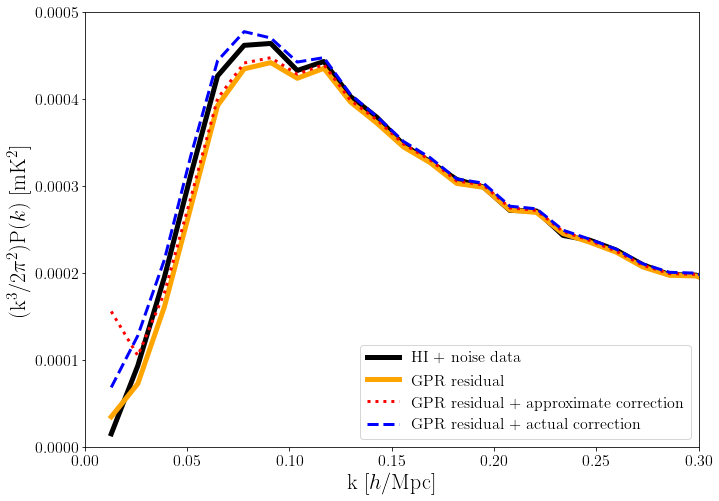

In [24]:
plt.figure(figsize=(11,8))
plt.plot(k, (k*k*k*HI_pk)/(2*np.pi*np.pi),ls='solid', c='k', lw=5, label = r'HI + noise data')
plt.plot(k, (k*k*k*res_pk)/(2*np.pi*np.pi),ls='solid', c='orange', lw=5, label = r'GPR residual')
plt.plot(k, (k*k*k*res_pk_corr)/(2*np.pi*np.pi),ls='dotted',c='r', lw=3, label = r'GPR residual + approximate correction')
plt.plot(k, (k*k*k*res_pk_truecorr)/(2*np.pi*np.pi),ls='dashed',c='b', lw=3, label = r'GPR residual + actual correction')

plt.legend(fontsize=16)
plt.xlim(0,0.3)
plt.ylim(0,0.0005)
plt.ylabel('(k$^3$/2$\pi^2$)P($k$) [mK$^2$]', fontsize=22)
plt.xlabel('k [$h$/Mpc]', fontsize=22)

The effect of the approximate bias correction (along the LoS only) is overall small (except on largest scales), while the actual correction has a larger effect since it takes into account spatial information.